## Import modules

In [1]:
import pickle
import random
import structs.functions as utils
from structs.types import Result

## Import comparison results and split
### Binary

In [2]:
# import
results_binary: list[Result] = []
for i in range(16):
    with open(f"results/binary/standard_balanced-cosine/{i}.pkl", "rb") as reader:
        results_binary.extend(pickle.load(reader))

random.shuffle(results_binary)
y_binary = [1 if (r.gesture1 == r.gesture2) else 0 for r in results_binary]

# train/test split
x_train_binary, x_test_binary, y_train_binary, y_test_binary = utils.train_test_split(results_binary, y_binary, 0.75)

# cross-validation folds
x_train_folds, x_test_folds, y_train_folds, y_test_folds = utils.train_test_folds(x_train_binary, y_train_binary, 12)

# all counts
print(f"Dataset: {len(results_binary)}")
print(f"  Train Split: {len(x_train_binary)}")
for idx, fold in enumerate(x_train_folds):
    print(f"    Train Fold {idx}: {len(fold)}")
for idx, fold in enumerate(x_test_folds):
    print(f"    Test Fold {idx}: {len(fold)}")
print(f"  Test Split: {len(x_test_binary)}")

Dataset: 478
  Train Split: 358
    Train Fold 0: 329
    Train Fold 1: 328
    Train Fold 2: 328
    Train Fold 3: 328
    Train Fold 4: 328
    Train Fold 5: 328
    Train Fold 6: 329
    Train Fold 7: 328
    Train Fold 8: 328
    Train Fold 9: 328
    Train Fold 10: 328
    Train Fold 11: 328
    Test Fold 0: 29
    Test Fold 1: 30
    Test Fold 2: 30
    Test Fold 3: 30
    Test Fold 4: 30
    Test Fold 5: 30
    Test Fold 6: 29
    Test Fold 7: 30
    Test Fold 8: 30
    Test Fold 9: 30
    Test Fold 10: 30
    Test Fold 11: 30
  Test Split: 120


### Multiclass

In [3]:
differences = utils.importGestureDifferences("test.csv", 5)

x_multiclass_diff = [x for x in results_binary if (x.gesture1 < 5 and x.gesture2 < 5) and (x.gesture1 != x.gesture2)]
x_multiclass_same = [x for x in results_binary if (x.gesture1 < 5 and x.gesture2 < 5) and (x.gesture1 == x.gesture2)]

# oversample missing stuff
x_multiclass = x_multiclass_same
for _ in range(len(x_multiclass_same) * 4):
    sample = x_multiclass_diff[random.randint(0, len(x_multiclass_diff) - 1)]
    x_multiclass.append(sample)

random.shuffle(x_multiclass)
y_multiclass = [differences[x.gesture1][x.gesture2] for x in x_multiclass]

_, x_test_multiclass, _, y_test_multiclass = utils.train_test_split(x_multiclass, y_multiclass, 0.75)

# count
print(f"Dataset: {len(x_test_multiclass)}")
print(f"  Test Split: {len(y_test_multiclass)}")

Dataset: 93
  Test Split: 93


## Finding thresholds
### Location

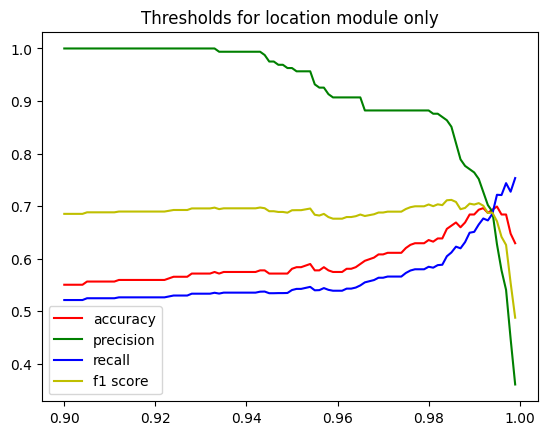

In [4]:
# graph different training thresholds
utils.plot_thresholds(
    threshold_name="location",
    title="Thresholds for location module only",
    iterator=range(900, 1000),
    test_function=utils.test_location,
    x_values=x_train_folds[0],
    y_values=y_train_folds[0])

Accuracy : 0.7931034482758621
Precision: 0.76
Recall   : 1.0
F1 Score : 0.8636363636363636


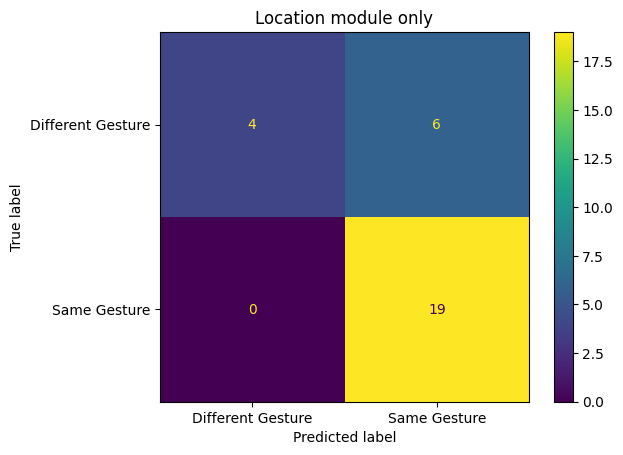

In [5]:
# test set threshold
utils.test_thresholds_binary(
    title="Location module only",
    x_values=x_test_folds[0],
    y_values=y_test_folds[0],
    thresholds={"location": 0.975},
    test_function=utils.test_location)

### Motion
#### Shoulder

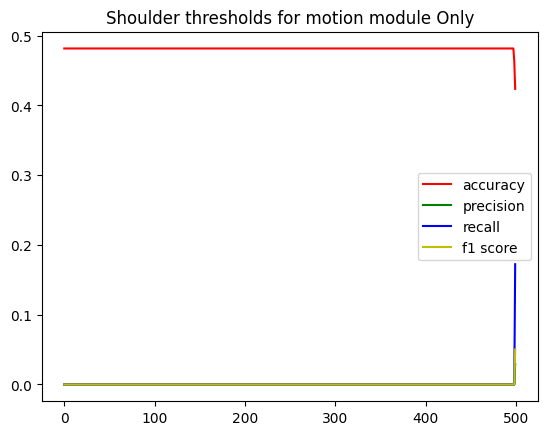

In [6]:
# graph different training thresholds
utils.plot_thresholds(
    threshold_name="motion_shoulder",
    title="Shoulder thresholds for motion module Only",
    iterator=range(500),
    scale=1,
    test_function=utils.test_motion,
    x_values=x_train_folds[1],
    y_values=y_train_folds[1],
    other_thresholds={
        "motion_elbow": 1,
        "motion_wrist": 1,
    })

Accuracy : 0.3333333333333333
Precision: 0.3333333333333333
Recall   : 1.0
F1 Score : 0.5


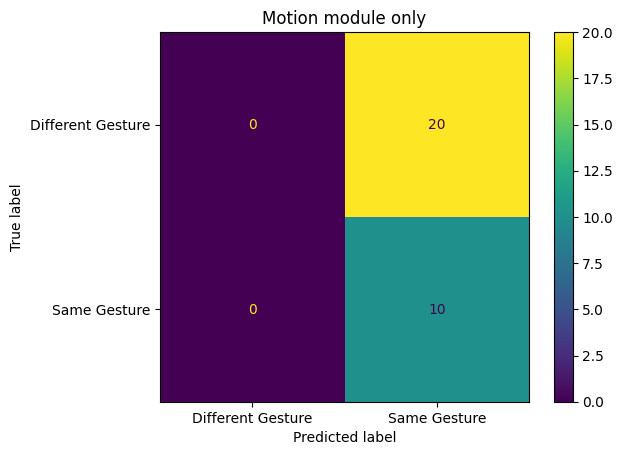

In [7]:
# test set threshold
utils.test_thresholds_binary(
    title="Motion module only",
    x_values=x_test_folds[1],
    y_values=y_test_folds[1],
    thresholds={
        "motion_shoulder": 0.5,
        "motion_elbow": 1,
        "motion_wrist": 1,
    },
    test_function=utils.test_motion)

#### Elbow

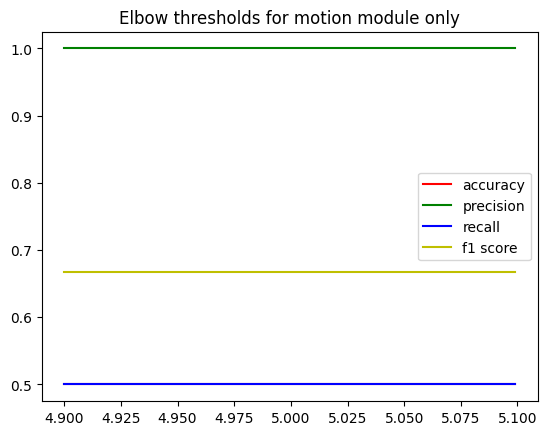

In [8]:
# graph different training thresholds
utils.plot_thresholds(
    threshold_name="motion_elbow",
    title="Elbow thresholds for motion module only",
    iterator=range(4900, 5100),
    scale=1000,
    test_function=utils.test_motion,
    x_values=x_train_folds[2],
    y_values=y_train_folds[2],
    other_thresholds={
        "motion_shoulder": 1,
        "motion_wrist": 1,
    })

Accuracy : 0.5333333333333333
Precision: 0.5333333333333333
Recall   : 1.0
F1 Score : 0.6956521739130435


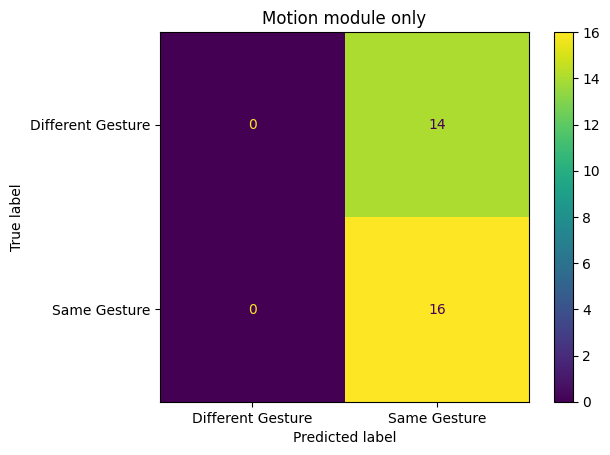

In [9]:
# test set threshold
utils.test_thresholds_binary(
    title="Motion module only",
    x_values=x_test_folds[2],
    y_values=y_test_folds[2],
    thresholds={
        "motion_shoulder": 1,
        "motion_elbow": 0.5,
        "motion_wrist": 1,
    },
    test_function=utils.test_motion)

#### Wrist

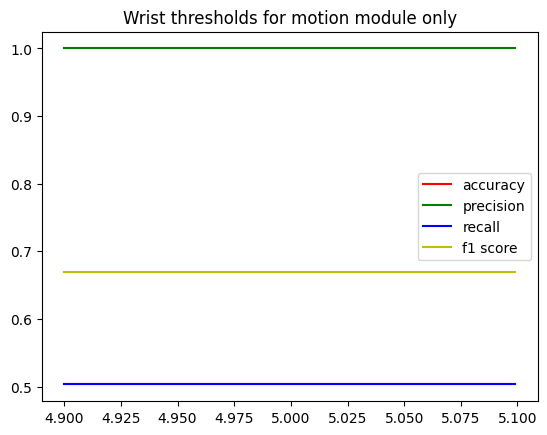

In [10]:
# graph different training thresholds
utils.plot_thresholds(
    threshold_name="motion_wrist",
    title="Wrist thresholds for motion module only",
    iterator=range(4900, 5100),
    scale=1000,
    test_function=utils.test_motion,
    x_values=x_train_folds[3],
    y_values=y_train_folds[3],
    other_thresholds={
        "motion_shoulder": 1,
        "motion_elbow": 1,
    })

Accuracy : 0.5
Precision: 0.5
Recall   : 1.0
F1 Score : 0.6666666666666666


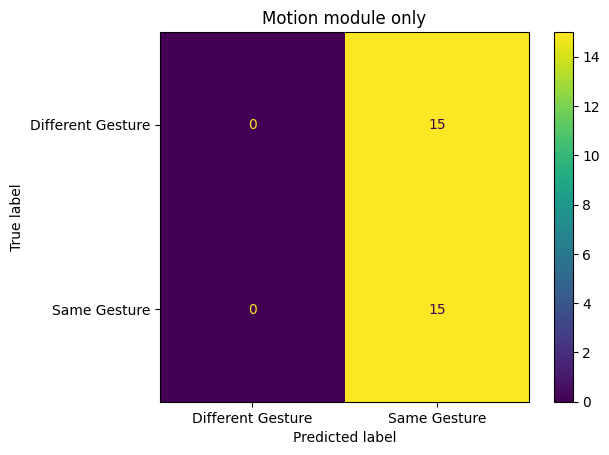

In [11]:
# test set threshold
utils.test_thresholds_binary(
    title="Motion module only",
    x_values=x_test_folds[3],
    y_values=y_test_folds[3],
    thresholds={
        "motion_shoulder": 1,
        "motion_elbow": 1,
        "motion_wrist": 0.5,
    },
    test_function=utils.test_motion)

### Shape

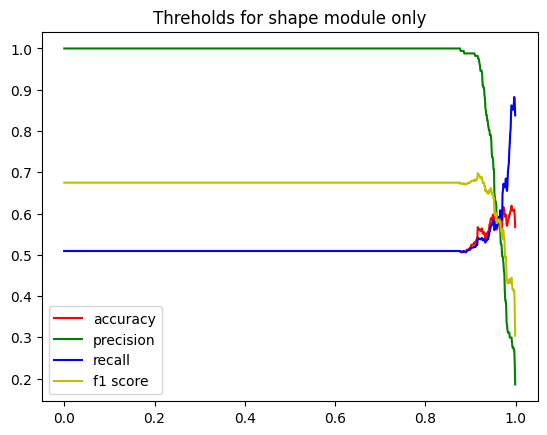

In [12]:
# graph different training thresholds
utils.plot_thresholds(
    threshold_name="shape",
    title="Threholds for shape module only",
    iterator=range(1000),
    test_function=utils.test_shape,
    x_values=x_train_folds[4],
    y_values=y_train_folds[4])

Accuracy : 0.4666666666666667
Precision: 0.4482758620689655
Recall   : 1.0
F1 Score : 0.6190476190476191


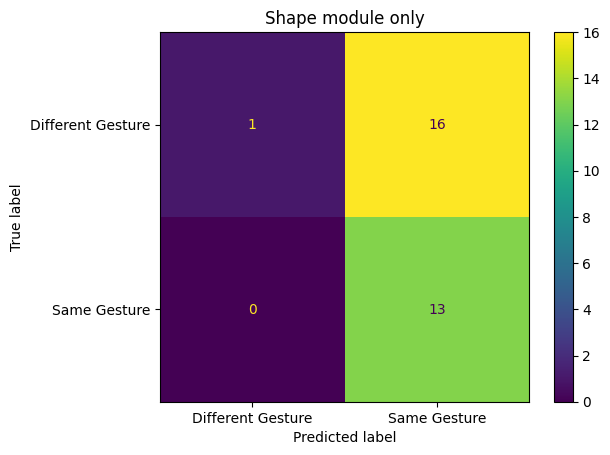

In [13]:
# test set threshold
utils.test_thresholds_binary(
    title="Shape module only",
    x_values=x_test_folds[4],
    y_values=y_test_folds[4],
    thresholds={
        "shape": 0.92,
    },
    test_function=utils.test_shape)

### Face

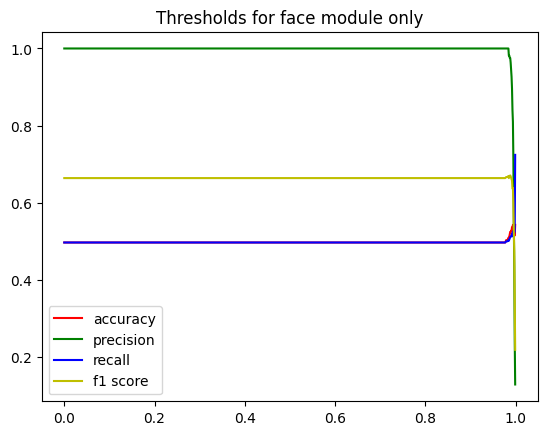

In [14]:
# graph different training thresholds
utils.plot_thresholds(
    threshold_name="face",
    title="Thresholds for face module only",
    iterator=range(1000),
    test_function=utils.test_face,
    x_values=x_train_folds[5],
    y_values=y_train_folds[5])

Accuracy : 0.6
Precision: 0.6190476190476191
Recall   : 0.7647058823529411
F1 Score : 0.6842105263157895


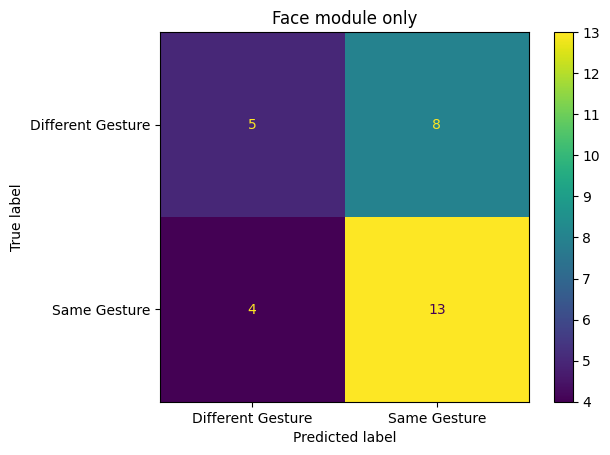

In [15]:
# test set threshold
utils.test_thresholds_binary(
    title="Face module only",
    x_values=x_test_folds[5],
    y_values=y_test_folds[5],
    thresholds={
        "face": 0.995,
    },
    test_function=utils.test_face)

## Optimizing thresholds
### Location

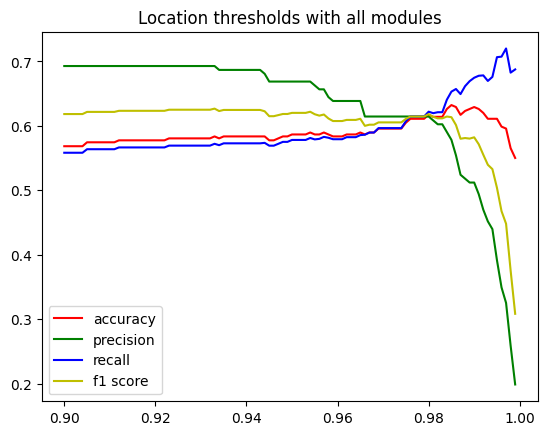

In [16]:
# graph different training thresholds
utils.plot_thresholds(
    threshold_name="location",
    title="Location thresholds with all modules",
    iterator=range(900, 1000),
    test_function=utils.test_with_face_binary,
    x_values=x_train_folds[6],
    y_values=y_train_folds[6],
    other_thresholds={
        "motion_shoulder": 0.5,
        "motion_elbow": 0.5,
        "motion_wrist": 0.5,
        "shape": 0.92,
        "face": 0.995,
    })

Accuracy : 0.5862068965517241
Precision: 0.5714285714285714
Recall   : 0.5714285714285714
F1 Score : 0.5714285714285714


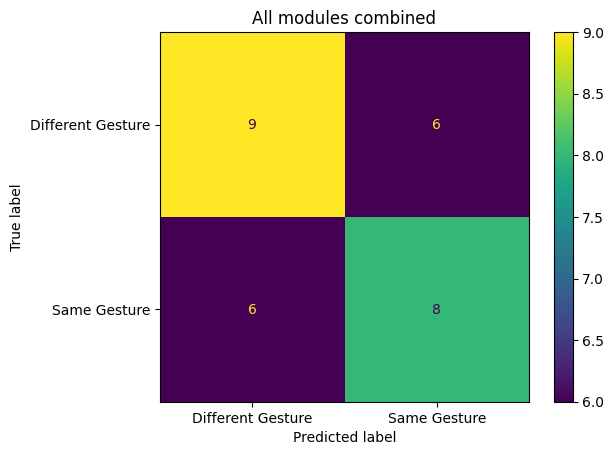

In [17]:
# test set threshold
utils.test_thresholds_binary(
    title="All modules combined",
    x_values=x_test_folds[6],
    y_values=y_test_folds[6],
    thresholds={
        "location": 0.975,
        "motion_shoulder": 0.5,
        "motion_elbow": 0.5,
        "motion_wrist": 0.5,
        "shape": 0.92,
        "face": 0.995,
    },
    test_function=utils.test_with_face_binary)

### Motion
#### Shoulder

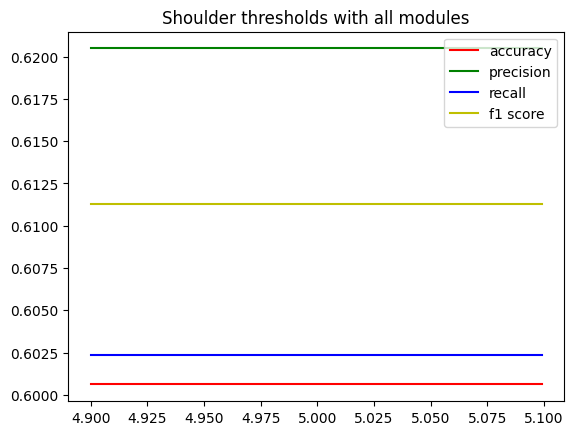

In [18]:
# graph different training thresholds
utils.plot_thresholds(
    threshold_name="motion_shoulder",
    title="Shoulder thresholds with all modules",
    iterator=range(4900, 5100),
    scale=1000,
    test_function=utils.test_with_face_binary,
    x_values=x_train_folds[7],
    y_values=y_train_folds[7],
    other_thresholds={
        "location": 0.975,
        "motion_elbow": 0.5,
        "motion_wrist": 0.5,
        "shape": 0.92,
        "face": 0.995,
    })

Accuracy : 0.6333333333333333
Precision: 0.6363636363636364
Recall   : 0.5
F1 Score : 0.56


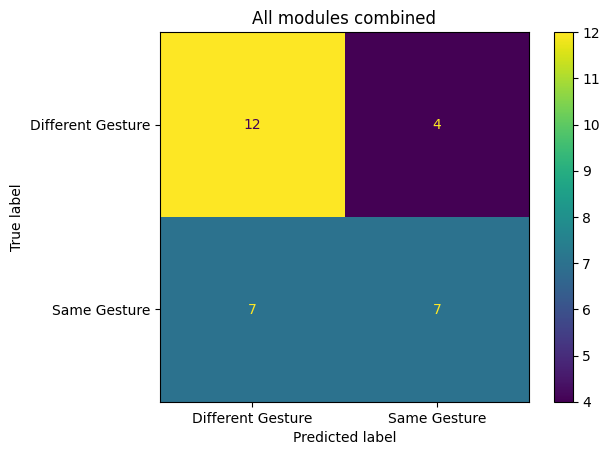

In [19]:
# test set threshold
utils.test_thresholds_binary(
    title="All modules combined",
    x_values=x_test_folds[7],
    y_values=y_test_folds[7],
    thresholds={
        "location": 0.975,
        "motion_shoulder": 0.5,
        "motion_elbow": 0.5,
        "motion_wrist": 0.5,
        "shape": 0.92,
        "face": 0.995,
    },
    test_function=utils.test_with_face_binary)

#### Elbow

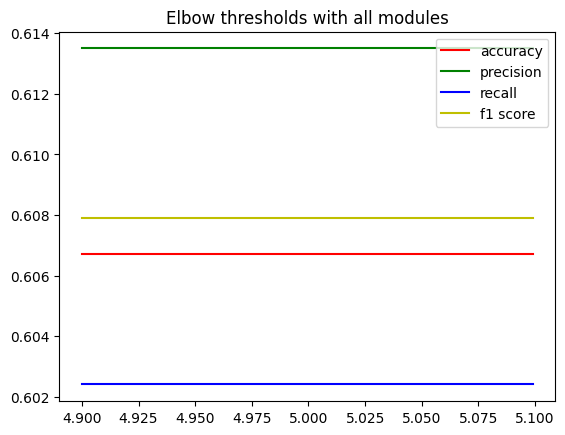

In [20]:
# graph different training thresholds
utils.plot_thresholds(
    threshold_name="motion_elbow",
    title="Elbow thresholds with all modules",
    iterator=range(4900, 5100),
    scale=1000,
    test_function=utils.test_with_face_binary,
    x_values=x_train_folds[8],
    y_values=y_train_folds[8],
    other_thresholds={
        "location": 0.975,
        "motion_shoulder": 0.5,
        "motion_wrist": 0.5,
        "shape": 0.92,
        "face": 0.995,
    })

Accuracy : 0.5666666666666667
Precision: 0.625
Recall   : 0.5882352941176471
F1 Score : 0.6060606060606061


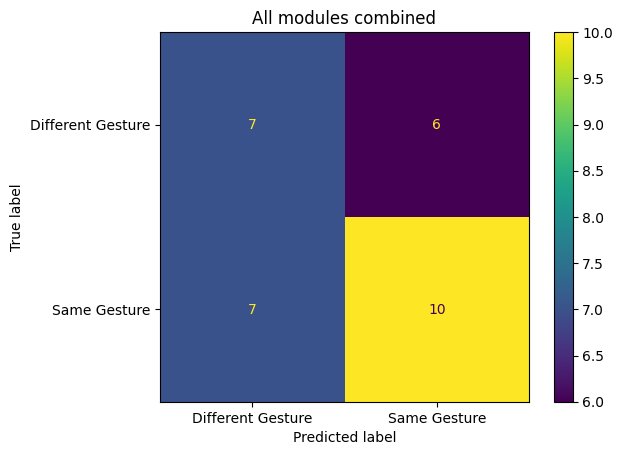

In [21]:
# test set threshold
utils.test_thresholds_binary(
    title="All modules combined",
    x_values=x_test_folds[8],
    y_values=y_test_folds[8],
    thresholds={
        "location": 0.975,
        "motion_shoulder": 0.5,
        "motion_elbow": 0.5,
        "motion_wrist": 0.5,
        "shape": 0.92,
        "face": 0.995,
    },
    test_function=utils.test_with_face_binary)

#### Wrist

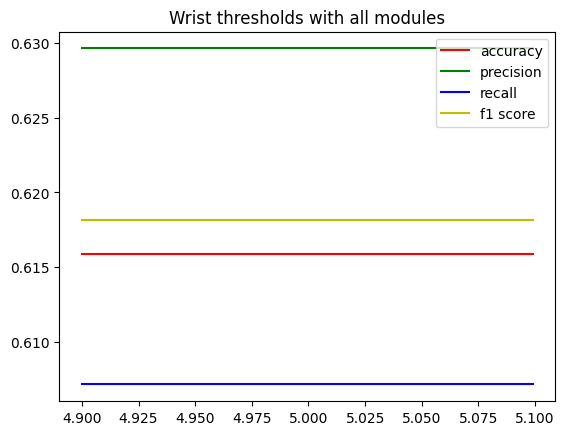

In [22]:
# graph different training thresholds
utils.plot_thresholds(
    threshold_name="motion_wrist",
    title="Wrist thresholds with all modules",
    iterator=range(4900, 5100),
    scale=1000,
    test_function=utils.test_with_face_binary,
    x_values=x_train_folds[9],
    y_values=y_train_folds[9],
    other_thresholds={
        "location": 0.975,
        "motion_shoulder": 0.5,
        "motion_elbow": 0.5,
        "shape": 0.92,
        "face": 0.995,
    })

Accuracy : 0.4666666666666667
Precision: 0.5714285714285714
Recall   : 0.4444444444444444
F1 Score : 0.5


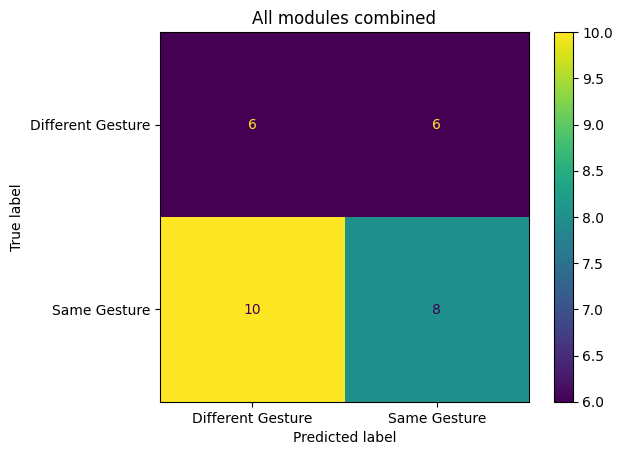

In [23]:
# test set threshold
utils.test_thresholds_binary(
    title="All modules combined",
    x_values=x_test_folds[9],
    y_values=y_test_folds[9],
    thresholds={
        "location": 0.975,
        "motion_shoulder": 0.5,
        "motion_elbow": 0.5,
        "motion_wrist": 0.5,
        "shape": 0.92,
        "face": 0.995,
    },
    test_function=utils.test_with_face_binary)

### Shape

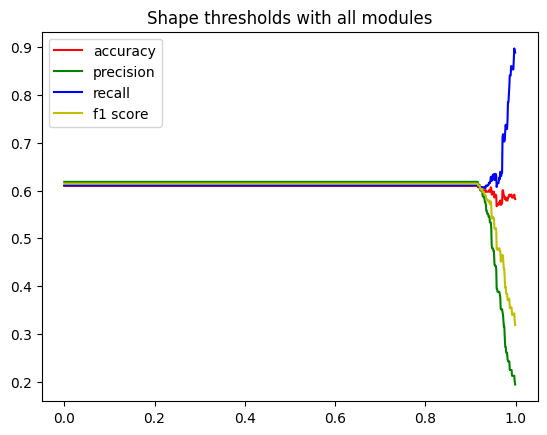

In [24]:
# graph different training thresholds
utils.plot_thresholds(
    threshold_name="shape",
    title="Shape thresholds with all modules",
    iterator=range(1000),
    test_function=utils.test_with_face_binary,
    x_values=x_train_folds[10],
    y_values=y_train_folds[10],
    other_thresholds={
        "location": 0.975,
        "motion_shoulder": 0.5,
        "motion_elbow": 0.5,
        "motion_wrist": 0.5,
        "face": 0.995,
    })

Accuracy : 0.5666666666666667
Precision: 0.5625
Recall   : 0.6
F1 Score : 0.5806451612903226


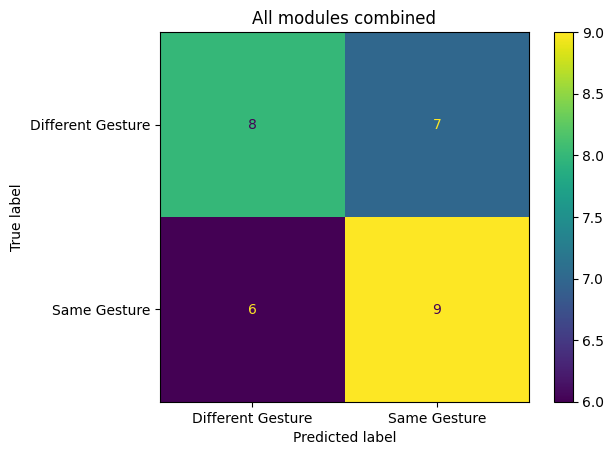

In [25]:
# test set threshold
utils.test_thresholds_binary(
    title="All modules combined",
    x_values=x_test_folds[10],
    y_values=y_test_folds[10],
    thresholds={
        "location": 0.975,
        "motion_shoulder": 0.5,
        "motion_elbow": 0.5,
        "motion_wrist": 0.5,
        "shape": 0.92,
        "face": 0.995,
    },
    test_function=utils.test_with_face_binary)

### Face

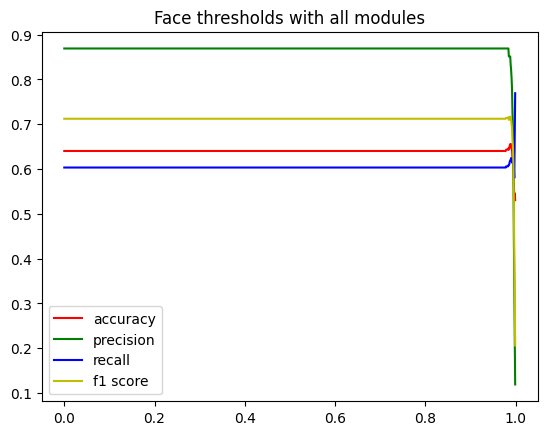

In [26]:
# graph different training thresholds
utils.plot_thresholds(
    threshold_name="face",
    title="Face thresholds with all modules",
    iterator=range(1000),
    test_function=utils.test_with_face_binary,
    x_values=x_train_folds[11],
    y_values=y_train_folds[11],
    other_thresholds={
        "location": 0.975,
        "motion_shoulder": 0.5,
        "motion_elbow": 0.5,
        "motion_wrist": 0.5,
        "shape": 0.92,
    })

Accuracy : 0.5666666666666667
Precision: 0.47058823529411764
Recall   : 0.6666666666666666
F1 Score : 0.5517241379310345


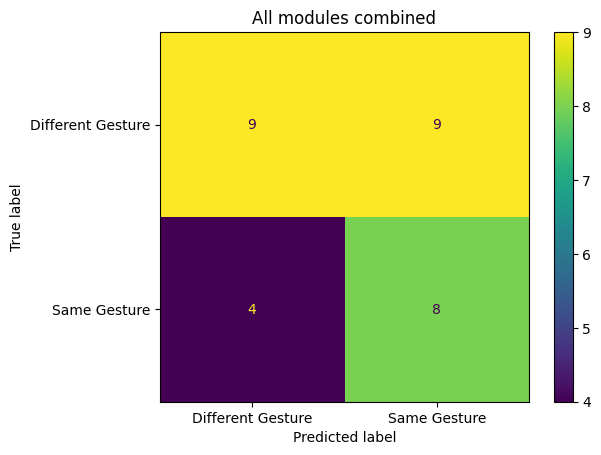

In [27]:
# test set threshold
utils.test_thresholds_binary(
    title="All modules combined",
    x_values=x_test_folds[11],
    y_values=y_test_folds[11],
    thresholds={
        "location": 0.975,
        "motion_shoulder": 0.5,
        "motion_elbow": 0.5,
        "motion_wrist": 0.5,
        "shape": 0.92,
        "face": 0.995,
    },
    test_function=utils.test_with_face_binary)

## Overall Binary Testing

Accuracy : 0.6166666666666667
Precision: 0.6065573770491803
Recall   : 0.6271186440677966
F1 Score : 0.6166666666666667


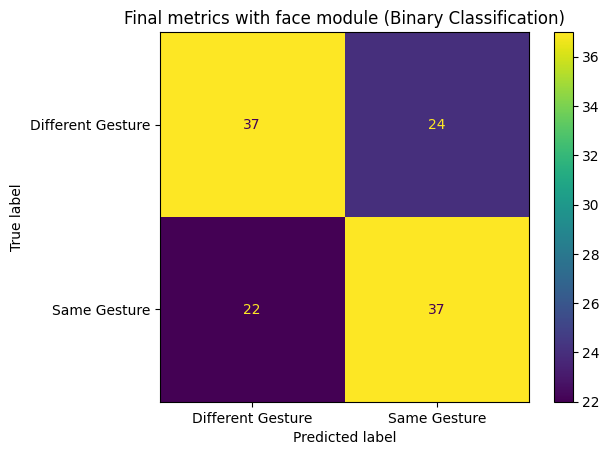

In [28]:
thresholds = {
    "location": 0.975,
    "motion_shoulder": 0.5,
    "motion_elbow": 0.5,
    "motion_wrist": 0.5,
    "shape": 0.92,
    "face": 0.995,
}

utils.test_thresholds_binary(
    title="Final metrics with face module (Binary Classification)",
    x_values=x_test_binary,
    y_values=y_test_binary,
    thresholds=thresholds,
    test_function=utils.test_with_face_binary)

## Overall Binary Testing without Face

In [ ]:
thresholds = {
    "location": 0.975,
    "motion_shoulder": 0.5,
    "motion_elbow": 0.5,
    "motion_wrist": 0.5,
    "shape": 0.92,
}

utils.test_thresholds_binary(
    title="Final metrics without face module (Binary Classification)",
    x_values=x_test_binary,
    y_values=y_test_binary,
    thresholds=thresholds,
    test_function=utils.test_without_face_binary)

## Overall Multiclass Testing

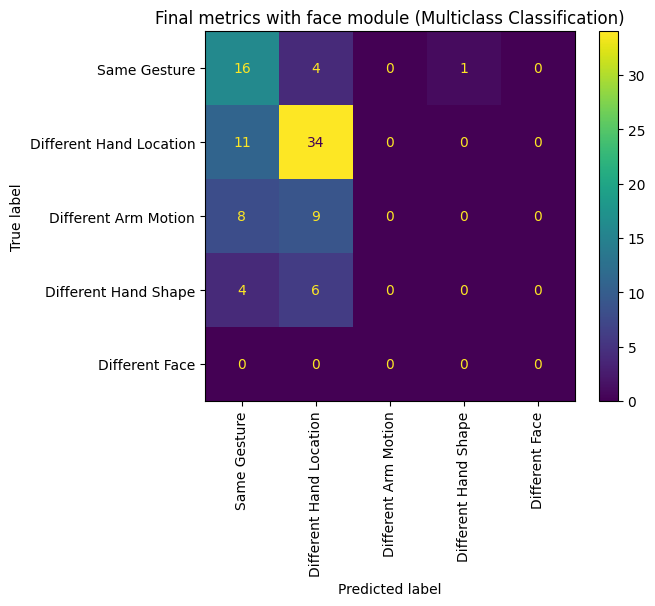

In [29]:
thresholds = {
    "location": 0.975,
    "motion_shoulder": 0.5,
    "motion_elbow": 0.5,
    "motion_wrist": 0.5,
    "shape": 0.92,
    "face": 0.995,
}

utils.test_thresholds_multiclass(
    title="Final metrics with face module (Multiclass Classification)",
    x_values=x_test_multiclass,
    y_values=y_test_multiclass,
    thresholds=thresholds,
    test_function=utils.test_with_face_multiclass)

## Overall Multiclass Testing without Face

In [ ]:
thresholds = {
    "location": 0.975,
    "motion_shoulder": 0.5,
    "motion_elbow": 0.5,
    "motion_wrist": 0.5,
    "shape": 0.92,
}

utils.test_thresholds_multiclass(
    title="Final metrics without face module (Multiclass Classification)",
    x_values=x_test_multiclass,
    y_values=y_test_multiclass,
    thresholds=thresholds,
    test_function=utils.test_without_face_multiclass)